# Introduction
The goal of this notebook is to show how we can handle textual features with high cardinality through textual embeddings

# Libraries, Functions and Global Variables

#### Import Libraries

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import argparse
import lightgbm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.decomposition import PCA

import helper
from transformers import AutoModel, AutoTokenizer, pipeline
import torch

# Import Data

In [7]:
df_train_clean = pd.read_csv('../data/processed/train_data_cleaned.csv')
df_test_clean = pd.read_csv('../data/processed/test_data_cleaned.csv')

df_train_clean.head()

,year_week,recipe_id,recipe_name,product_type,calories,carbs,cooking_time,cuisine,description,difficulty,...,dish_types,seasons,protein_types,proteins,course_type,cooking_tip,meta_tags,percentage_of_local_ingredients,protein_cuts,sales
0,201801,14919,Shrimp & Broccoli Stir-Fry,2 person,687.0,99.2,time_level_4,asian,"For this dish, once the ingredients are preppe...",easy,...,"fish_and_side,stir_fry",all_seasons,shellfish,29.5,main,NaN,healthy_choice,0.0,NaN,3567
1,201801,14920,Caramelized Cabbage Pasta,2 person,779.0,81.3,time_level_4,new_american,Red lentil penne makes this pasta dish a pleas...,easy,...,pasta,all_seasons,no_protein,30.0,main,NaN,quick,0.0,no_cut,2532
2,201801,14449,AFC Vegetarian Pad Thai,z_amazon,642.0,92.8,NaN,NaN,Pad Thai is one of our favorite street foods t...,easy,...,NaN,NaN,NaN,16.2,NaN,NaN,NaN,NaN,NaN,6
3,201801,11963,Shrimp & Broccoli Stir-Fry,family,620.0,93.2,time_level_4,asian,"For this dish, once the ingredients are preppe...",easy,...,"fish_and_side,stir_fry",all_seasons,shellfish,28.7,main,NaN,healthy_choice,0.0,NaN,642
4,201801,14914,Chicken & Pasta Soup,family,610.0,67.0,time_level_4,new_american,"We've never met a chicken soup we didn't like,...",easy,...,soup,all_seasons,poultry,36.0,main,NaN,healthy_choice,0.0,breast,1492


# Pre-Processing Data

#### Replace missing values with 'unk' in categorical features

In [6]:
df_train_clean[helper.CAT_FEATURES_FILL_NAN] = df_train_clean[helper.CAT_FEATURES_FILL_NAN].fillna("unk")
df_test_clean[helper.CAT_FEATURES_FILL_NAN] = df_test_clean[helper.CAT_FEATURES_FILL_NAN].fillna("unk")

#### Convert all categorical features in lower case

In [7]:
for i in df_train_clean.columns:
    if df_train_clean[i].dtype == 'O':
        df_train_clean[i] = df_train_clean[i].str.lower()
        df_test_clean[i] = df_test_clean[i].str.lower()

#### Create column with date starting on monday 

In [8]:
df_train_clean = helper.create_week_day(df_train_clean.copy())
df_test_clean = helper.create_week_day(df_test_clean.copy())

#### Alert to make sure all dates have 7 days between them

In [9]:
# check for training set
weekdays = sorted(df_train_clean["week_day"].unique())
assert len(np.unique(np.diff(weekdays))) == 1, "At least one date is not separated by 7 days"

# check for test set
weekdays = sorted(df_test_clean["week_day"].unique())
assert len(np.unique(np.diff(weekdays))) == 1, "At least one date is not separated by 7 days"

#### Add number of products feature to the data frame which is the number of recipes available by week

In [10]:
#Add feature to train set
df_train_clean = helper.create_n_recipes_feature(df_train_clean.copy())

#Add feature to test set
df_test_clean = helper.create_n_recipes_feature(df_test_clean.copy())

# Embeddings

## Loading the pretrained tokenizer and model from hugging face

 - There are different models that we can try, and you check them here: https://huggingface.co/models?pipeline_tag=feature-extraction
 - It is important to use the model's tokenizer so that it receives the data in a proper format and they are also useful since they already clean up the data for you.
 - Each tokenizer will have different ways of dealing with the data, therefore it is important to read about them.

In [11]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Let's pick the 2 features with the highest cardinality in the dataset `recipe_name` and `description`, with 931 and 981 different classes, respectively. 

- We will get the hidden state from the CLS token which represents an entire sequence of text and helps us not to deal with a 768 array for each token in a string, we just need to deal with one.

- the 768 array is specific to this model, other models can return only 100 or 200, etc.

In [12]:
df_train_clean['recipe_name'] = df_train_clean['recipe_name'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state[:,0,:].detach().numpy()[0])
df_train_clean['description'] = df_train_clean['description'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state[:,0,:].detach().numpy()[0])

In [93]:
df_test_clean['recipe_name'] = df_test_clean['recipe_name'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state[:,0,:].detach().numpy()[0])
df_test_clean['description'] = df_test_clean['description'].apply(lambda x: model(**tokenizer(x, return_tensors="pt")).last_hidden_state[:,0,:].detach().numpy()[0])

## Now we have a array with 768 elements for each string in the dataset, so 768 new features that we can handle using different approaches, for example:
 - getting statistics like average, percentiles, min, max, standard deviation
 - applying a dimensionality reduction approch like PCA

 Let's apply PCA to get 2 components, so that we can plot them and see if they have some predictive power by coloring different bins of sales

In [94]:
# get a 768 column dataframe for recipe_name and description
recipe_name_df = helper.get_embeddings_df(df_train_clean, 'recipe_name')
description_df = helper.get_embeddings_df(df_train_clean, 'description')

In [83]:
# apply PCA
pca = PCA(n_components=2)
recipe_name_2_components = pd.DataFrame(pca.fit_transform(recipe_name_df), columns = ['X', 'Y'])

In [84]:
# binning the sales into 5 bins with the same quantity of points in each bin
# our sales are highly skewed, therefore we will have a lot of points in bin 0
from sklearn.preprocessing import KBinsDiscretizer
bin = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
df_train_clean['bin_sales'] = bin.fit_transform(df_train_clean['sales'].values.reshape(-1, 1) )

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


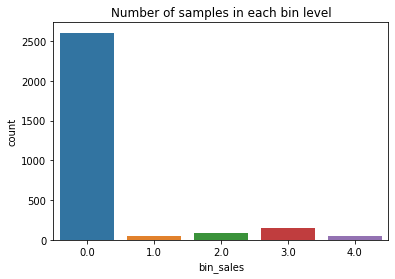

In [87]:
sns.countplot(df_train_clean.bin_sales)
plt.title("Number of samples in each bin level")
plt.show()

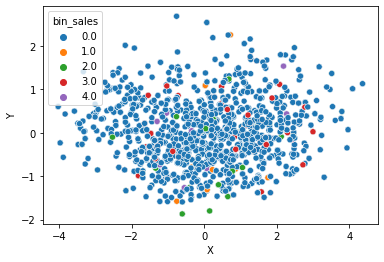

In [88]:
# add bins to our PCA dataset
recipe_name_2_components['bin_sales'] = df_train_clean['bin_sales'] 
sns.scatterplot(data=recipe_name_2_components, x='X', y='Y', hue='bin_sales', palette="tab10")
plt.show()

From the above chart is not clear the predictive power of these 2 components, maybe because these feature is not important for this problem!

Nevertheless, the goal here was to show how to deal with categorical features with high cardinality, so let's use these features in our model!!

In [95]:
recipe_name_df_test = helper.get_embeddings_df(df_test_clean, 'recipe_name')
description_df_test = helper.get_embeddings_df(df_test_clean, 'description')

In [100]:
# identify the number of components needed based on variance explained
recipe_name_components, recipe_name_components_test = helper.apply_PCA(recipe_name_df, recipe_name_df_test, 'recipe_name', variance_explained=0.8)
description_components, description_components_test = helper.apply_PCA(description_df, description_df_test, 'description', variance_explained=0.8)

In [106]:
# merge with dataframe
df_train_clean = pd.merge(df_train_clean, recipe_name_components, left_index=True, right_index=True, how='left')
df_train_clean = pd.merge(df_train_clean, description_components, left_index=True, right_index=True, how='left')
df_test_clean = pd.merge(df_test_clean, recipe_name_components_test, left_index=True, right_index=True, how='left')
df_test_clean = pd.merge(df_test_clean, description_components_test, left_index=True, right_index=True, how='left')

In [107]:
df_train_clean.shape

(2939, 92)

# Modeling

In [108]:
args = helper.parse_arguments()

#### Create Model Pipeline
**Features:**
   * Ordinal Encoding for Categorical features which assign a ordered label to each class (1,2,3...)
   * SimpleImputer inputs missing values in Numerical Features
   * TFIDF for text and tag features tries to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.
   * Apply LGBM

In [109]:
model = Pipeline([
    ("feature_preprocessor", ColumnTransformer([
        # Note: Ordinal encoding works quite well for the models based on decision trees
        ("categorical", OrdinalEncoder(handle_missing=args.handle_missing), helper.CATEGORICAL_FEATURES),
        ## Numerical features will be passed through the model with no inputation on missing values
        ("numerical", "passthrough", helper.NUMERICAL_FEATURES),
        ("meta_tags_tfidf", TfidfVectorizer(min_df=args.min_df), helper.TAGS_FEATURES[0]),
        ("carbs_content_tfidf", TfidfVectorizer(min_df=args.min_df), helper.TAGS_FEATURES[1]),
    ])),
    ("regressor", lightgbm.LGBMRegressor(
        n_estimators= args.n_estimators,
        objective= args.objective,
        num_leaves=args.num_leaves,
        max_depth=args.max_depth,
        min_child_samples=args.min_child_samples,
        learning_rate=args.learning_rate,
        colsample_bytree=args.colsample_bytree,
        verbosity=args.verbosity,
        extra_trees=args.extra_trees,
        random_state=args.random_state,
    )),
])

#### Create an auxiliar list to control the creation of train folds and val folds

In [110]:
year_weeks = sorted(df_train_clean.year_week.unique())

#### Start spliting the data into 5 weeks validation and the previous weeks for training

In [112]:
FEATURES = helper.FEATURES+recipe_name_components.columns.tolist()+description_components.columns.tolist()

In [113]:
errors = []
n_folds = args.folds
n_of_weeks_to_predict = args.weeks

for fold in range(n_folds):
    print(f"Running CV on fold {fold + 1} / {n_folds}")
    week_start = year_weeks[-(fold + 1) * n_of_weeks_to_predict]
    week_end = year_weeks[-fold * n_of_weeks_to_predict - 1]

    print(f"  Running validation on weeks {week_start} - {week_end}")

    df_train = df_train_clean[df_train_clean.year_week < week_start]
    df_val = df_train_clean[(df_train_clean.year_week >= week_start) & (df_train_clean.year_week <= week_end)]

    print(f"  Number of training samples: {len(df_train)}")
    print(f"  Number of validation samples: {len(df_val)}")

    assert len(df_val.year_week.unique()) == n_of_weeks_to_predict, f"The prediction must be done for {n_of_weeks_to_predict}"

    print("  Training the model...")
    model.fit(df_train.loc[:,FEATURES], df_train.sales, regressor__sample_weight=helper.estimate_sample_weights(df_train, weight = args.weight))
    y_predicted = np.clip(model.predict(df_val.loc[:,FEATURES]), 0, np.inf).astype(int)
    error = helper.rmse(df_val.sales, y_predicted)

    print(f"  RMSE: {error:.2f}")
    errors.append(error)

print(f"Average RMSE accross {n_folds} folds: {np.mean(errors):.2f}")

Running CV on fold 1 / 5
  Running validation on weeks 201940 - 201944
  Number of training samples: 2737
  Number of validation samples: 202
  Training the model...
  RMSE: 3053.86
Running CV on fold 2 / 5
  Running validation on weeks 201935 - 201939
  Number of training samples: 2531
  Number of validation samples: 206
  Training the model...
  RMSE: 3172.72
Running CV on fold 3 / 5
  Running validation on weeks 201930 - 201934
  Number of training samples: 2331
  Number of validation samples: 200
  Training the model...
  RMSE: 2980.67
Running CV on fold 4 / 5
  Running validation on weeks 201925 - 201929
  Number of training samples: 2131
  Number of validation samples: 200
  Training the model...
  RMSE: 3315.62
Running CV on fold 5 / 5
  Running validation on weeks 201920 - 201924
  Number of training samples: 1931
  Number of validation samples: 200
  Training the model...
  RMSE: 3547.24
Average RMSE accross 5 folds: 3214.02
